This notebook is written to prototype a conversion from the "ACAPS" humdata.org database into the epidemicforecasting.org format.

For anything that is in the source ACAPS that we'd _like_ to be in target EF, we'll write a function to convert it.

This includes data that EF already has, so that we can fill in any gaps.



In [32]:
import pandas as pd
import numpy as np
import re


In [103]:
source_data = pd.read_csv("../../../data/epidemicforecasting/epimodel-covid-data/dataimport/20200423-acaps-covid-19-goverment-measures-dataset-v10 - Database.csv")

In [104]:
source_data.sample(5)

,ID,COUNTRY,ISO,ADMIN_LEVEL_NAME,PCODE,REGION,LOG_TYPE,CATEGORY,MEASURE,TARGETED_POP_GROUP,COMMENTS,NON_COMPLIANCE,DATE_IMPLEMENTED,SOURCE,SOURCE_TYPE,LINK,ENTRY_DATE,Alternative source
1687,5903,Czech Republic,CZE,NaN,NaN,Europe,Introduction / extension of measures,Public health measures,Introduction of isolation and quarantine policies,Yes,General practitioners will only terminate the ...,Not applicable,22/04/2020,Ministry of Health,Government,https://koronavirus.mzcr.cz/pro-ukonceni-karan...,17/04/2020,NaN
506,1045,Bahamas,BHS,NaN,NaN,Americas,Introduction / extension of measures,Public health measures,General recommendations,No,MoH published hygiene recommednations for prev...,NaN,22/01/2020,Ministry of Health,Government,http://www.bahamas.gov.bs/wps/wcm/connect/6aaa...,20/03/2020,NaN
3813,1387,Malaysia,MYS,Sarawak,NaN,Asia,Introduction / extension of measures,Social distancing,Limit public gatherings,No,any public gathering involving more than 500 p...,Not available,12/03/2020,The Star,Media,https://www.thestar.com.my/news/nation/2020/03...,22/03/2020,NaN
2308,738,France,FRA,NaN,NaN,Europe,Introduction / extension of measures,Public health measures,Health screenings in airports and border cross...,No,NaN,Not available,16/03/2020,U.S. Embassy in France,Government,https://fr.usembassy.gov/covid-19-information/,16/03/2020,NaN
2028,502,Eritrea,ERI,NaN,NaN,Africa,Introduction / extension of measures,Public health measures,Awareness campaigns,No,NaN,Not applicable,12/03/2020,Africa News,Media,https://www.africanews.com/2020/03/12/eritrea-...,16/03/2020,NaN


In [105]:
source_data.COUNTRY.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China',
       'China, Hong Kong Special Administrative Region', 'Colombia',
       'Comoros', 'Congo', 'Congo DR', 'Costa Rica', "Côte d'Ivoire",
       'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Czech republic',
       'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Gren

Now let's see what the target data source looks like.

In [106]:
ef_cm = pd.read_csv(
    "../../../data/epidemicforecasting/epimodel-covid-data/sources/COVID 19 Containment measures data.csv",
    parse_dates=['Date Start','Date end intended']).dropna(subset=['Country'])

    

In [107]:
ef_cm.loc[ef_cm.Keywords.str.contains('curfew',na=False),:]

,ID,Applies To,Country,Date Start,Date end intended,Description of measure implemented,Exceptions,Implementing City,Implementing State/Province,Keywords,Quantity,Source,Target city,Target country,Target region,Target state
82,NaN,NaN,Slovenia,2020-03-20,NaT,Slovenia enforced a ban on all kinds of public...,NaN,NaN,NaN,"blanket curfew - no symptoms, compulsory isola...",NaN,https://www.euractiv.com/section/coronavirus/s...,NaN,NaN,NaN,NaN
228,78,NaN,Italy,2020-03-08,NaT,avoiding moves from place of residence,NaN,NaN,NaN,blanket curfew - no symptoms,NaN,https://www.mzv.cz/rome/cz/viza_a_konzularni_i...,NaN,NaN,NaN,NaN
576,455,NaN,Serbia,2020-03-18,NaT,"As of Wednesday morning at ten o'clock, in all...",NaN,NaN,NaN,"blanket curfew - no symptoms, elderly",NaN,https://www.rts.rs/page/stories/sr/%D0%9A%D0%B...,NaN,NaN,NaN,NaN
753,NaN,Bavaria,Germany,2020-03-20,NaT,Bavaria was the first state to declare a curfe...,NaN,NaN,Bavaria,blanket curfew - no symptoms,NaN,https://www.nordkurier.de/politik-und-wirtscha...,NaN,NaN,NaN,NaN
757,NaN,"Saxony, Bavaria, Saarland",Germany,2020-03-22,NaT,Saxony joined Bavaria and the Saarland in proh...,NaN,NaN,"Bavaria, Saarland, Saxony",blanket curfew - no symptoms,NaN,https://medienservice.sachsen.de/medien/news/2...,NaN,NaN,NaN,NaN
821,790,NaN,Albania,2020-03-13,NaT,"From 13 March, Albania implemented a hardening...",NaN,NaN,NaN,"blanket curfew - no symptoms, domestic travel ban",NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN
905,NaN,NaN,Palestine,2020-03-22,2020-04-05,Prime Minister Shtayyeh announced a ban for 2 ...,NaN,NaN,NaN,blanket curfew - no symptoms,NaN,NaN,NaN,NaN,NaN,NaN
911,NaN,NaN,US:Georgia,2020-03-20,NaT,curfew from 9PM to 7AM (unless medical or othe...,NaN,South Fulton,NaN,blanket curfew - no symptoms,NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN
1021,881,NaN,Greece,2020-03-23,2020-04-06,"On 22 March, the Greek government announced a ...",prescribed set of reasons,NaN,NaN,"blanket curfew - no symptoms, domestic travel ban",NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN
1037,NaN,NaN,US: Illinois,2020-03-21,NaT,all individuals currently living within the St...,NaN,NaN,NaN,"blanket curfew - no symptoms, social distancing",NaN,https://www2.illinois.gov/Pages/Executive-Orde...,NaN,NaN,NaN,NaN


In [108]:
ef_cm.Quantity.value_counts()

1.000000e+00    34
0.000000e+00    27
1.000000e+02    26
5.000000e+01    19
1.000000e+01    19
2.000000e+00    16
1.000000e+03    11
5.000000e+02    10
2.500000e+02     8
2.500000e+01     4
2.000000e+01     3
2.000000e+03     3
3.000000e+01     3
5.000000e+00     3
3.000000e+02     2
3.000000e+00     2
2.000000e+02     2
4.000000e+00     2
1.200000e+02     2
5.000000e+03     2
2.780000e+02     1
1.561000e+03     1
7.500000e+11     1
3.166640e+05     1
2.519000e+03     1
2.561000e+03     1
1.250000e+05     1
1.073000e+04     1
8.400000e+03     1
1.039000e+03     1
                ..
1.561300e+04     1
1.269000e+03     1
8.070000e+02     1
2.062000e+03     1
1.430000e+04     1
1.455000e+03     1
3.000000e+04     1
4.373500e+04     1
6.438000e+03     1
6.326000e+03     1
2.028000e+03     1
3.908900e+04     1
5.271000e+03     1
1.086400e+04     1
2.220000e+02     1
7.000000e+02     1
5.840000e+02     1
4.000000e+03     1
3.160000e+02     1
1.264000e+03     1
1.641000e+03     1
1.451400e+04

OK great. So what if we picked one category where `ACAPS` was useful, wrote a mapping from that category to one in `ef_cm`, converted it to `ef_cm` format, and then imported it into the dataset itself?

## Explore ACAPS categories

ACAPS follow a rough hierarchy of "category" and "measure".

First, the data needs a bit of tidying up - let's trim whitespace out of the relevant columns.

In [109]:
source_data.CATEGORY = source_data.CATEGORY.str.strip()
source_data.MEASURE = source_data.MEASURE.str.strip()
#and because we want source_data without a sublocale to merge we're going to change NaN to a ''.
#need to change NA to a zero-length string so that it'll list as a unique item.
source_data.loc[:,"ADMIN_LEVEL_NAME_MERGEABLE"]=source_data.ADMIN_LEVEL_NAME
source_data.loc[pd.isnull(source_data.ADMIN_LEVEL_NAME),"ADMIN_LEVEL_NAME_MERGEABLE"]=''

#there's a few source data items with a date misssing - let's remove those.
source_data = source_data.loc[source_data['DATE_IMPLEMENTED'].isnull()==False]

Here's list of each CATEGORY with all of the MEASURE items in each category.

In [110]:
for c in source_data.CATEGORY.unique():
    print(c)
    print(source_data.loc[source_data.CATEGORY==c,'MEASURE'].unique())
    print("\n")

Public health measures
['Health screenings in airports and border crossings'
 'Introduction of isolation and quarantine policies' 'Awareness campaigns'
 'Strengthening the public health system'
 'Other public health measures enforced' 'General recommendations'
 'Requirement to wear protective gear in public'
 'Amendments to funeral and burial regulations' 'Testing policy'
 'Psychological assistance and medical social work'
 'Mass population testing' 'strengthening the public health system'
 'testing policy' 'Border closure']


Governance and socio-economic measures
['Emergency administrative structures activated or established'
 'Limit product imports/exports' 'State of emergency declared'
 'Economic measures' 'Military deployment']


Social distancing
['Limit public gatherings' 'Schools closure'
 'Changes in prison-related policies' 'Public services closure'
 'limit public gatherings']


Movement restrictions
['Border closure' 'Border checks' 'International flights suspension'
 'Surve

Lockdown is a good one to start with. `ef` coverage is likely to be quite good, which makes it a useful test case. Let's try importing those.

## Explore EF data

In [111]:
ef_cm_n.loc[ef_cm_n.Keywords=='school closure','Country'].unique()

NameError: name 'ef_cm_n' is not defined

In [112]:
ef_cm_n.Keywords.unique()

NameError: name 'ef_cm_n' is not defined

## Importing single category from ACAPS to ef format

In [113]:
source_data.loc[(source_data.CATEGORY=="Lockdown") & (source_data.MEASURE=="Full lockdown"),]

,ID,COUNTRY,ISO,ADMIN_LEVEL_NAME,PCODE,REGION,LOG_TYPE,CATEGORY,MEASURE,TARGETED_POP_GROUP,COMMENTS,NON_COMPLIANCE,DATE_IMPLEMENTED,SOURCE,SOURCE_TYPE,LINK,ENTRY_DATE,Alternative source,ADMIN_LEVEL_NAME_MERGEABLE
105,1982,Algeria,DZA,NaN,NaN,Africa,Introduction / extension of measures,Lockdown,Full lockdown,Yes,Bilda (complete confinement - all movement in ...,NaN,23/03/2020,Gardaworld,Other organisations,https://www.garda.com/crisis24/news-alerts/325...,24/03/2020,NaN,
114,5409,Algeria,DZA,Blida,NaN,Africa,Introduction / extension of measures,Lockdown,Full lockdown,Yes,Blida extended until at least 19. april 2020,Not available,01/04/2020,International SOS,Other organisations,https://pandemic.internationalsos.com/2019-nco...,15/04/2020,NaN,Blida
222,4666,Antigua and Barbuda,ATG,NaN,NaN,Americas,Introduction / extension of measures,Lockdown,Full lockdown,No,"A 24 Hour curfew from Thursday, April 2 from 1...",Other (add in comments),02/04/2020,AB govt.,Government,https://ab.gov.ag/pdf/covid_news/mar_31_2020_2...,10/04/2020,NaN,
223,4736,Antigua and Barbuda,ATG,NaN,NaN,Americas,Introduction / extension of measures,Lockdown,Full lockdown,No,extension of 24 hr curfew from until April 16 ...,Other (add in comments),09/04/2020,AB govt.,Government,https://ab.gov.ag/pdf/covid_news/Essential_Ser...,10/04/2020,NaN,
500,4741,Azerbaijan,AZE,NaN,NaN,Asia,Introduction / extension of measures,Lockdown,Full lockdown,Yes,only allowed to leave place of residences unde...,Not available,24/03/2020,Travel Authority,Government,https://azerbaijan.travel/covid-19-en,10/04/2020,NaN,
536,4774,Bahamas,BHS,NaN,NaN,Americas,Introduction / extension of measures,Lockdown,Full lockdown,No,"24-hour curfew, with some exceptions for esse...",Not available,24/03/2020,Prime Minister Office,Government,http://www.bahamas.gov.bs/wps/portal/public/go...,NaN,NaN,
542,4884,Bahamas,BHS,NaN,NaN,Americas,Introduction / extension of measures,Lockdown,Full lockdown,No,All residents will be placed on a 24-hour curf...,Not available,24/03/2020,Bahamas Govt.,Government,http://www.bahamas.gov.bs/wps/portal/public/go...,12/04/2020,NaN,
549,4891,Bahamas,BHS,NaN,NaN,Americas,Introduction / extension of measures,Lockdown,Full lockdown,No,Emergency Order remains in effect until Wedne...,Not available,31/03/2020,Bahamas Govt.,Government,http://www.bahamas.gov.bs/wps/portal/public/go...,12/04/2020,NaN,
663,5203,Barbados,BRB,NaN,NaN,Americas,Introduction / extension of measures,Lockdown,Full lockdown,No,"24-hour curfew from 6:00 p.m. on Friday, April...",Other (add in comments),03/04/2020,Gov. Info Services,Government,https://gisbarbados.gov.bb/blog/24-hour-curfew...,14/04/2020,NaN,
1942,6370,El Salvador,SLV,NaN,NaN,Americas,Introduction / extension of measures,Lockdown,Full lockdown,Yes,Port of La Libertad cordoned off by the Armed ...,Arrest/Detention,18/04/2020,elsalvador.com,Media,https://www.elsalvador.com/fotogalerias/notici...,20/04/2020,NaN,


In [114]:
source_data.columns

Index(['ID', 'COUNTRY', 'ISO', 'ADMIN_LEVEL_NAME', 'PCODE', 'REGION',
       'LOG_TYPE', 'CATEGORY', 'MEASURE', 'TARGETED_POP_GROUP', 'COMMENTS',
       'NON_COMPLIANCE', 'DATE_IMPLEMENTED', 'SOURCE', 'SOURCE_TYPE', 'LINK',
       'ENTRY_DATE', 'Alternative source', 'ADMIN_LEVEL_NAME_MERGEABLE'],
      dtype='object')

In [115]:
ef_cm.columns

Index(['ID', 'Applies To', 'Country', 'Date Start', 'Date end intended',
       'Description of measure implemented', 'Exceptions', 'Implementing City',
       'Implementing State/Province', 'Keywords', 'Quantity', 'Source',
       'Target city', 'Target country', 'Target region', 'Target state'],
      dtype='object')

We'll need to map country names. If we assume each source has consistent country names then we can create a mapping CSV that records the names. I'll do this in a Gsheet and then save to CSV.

## Sort out country names

In [116]:
pd.DataFrame(ef_cm.Country.unique()).to_csv("../../../data/epidemicforecasting/ef_countryname_lexicon.csv")


#https://stackoverflow.com/questions/35268817/unique-combinations-of-values-in-selected-columns-in-pandas-data-frame-and-count
grouping_cols = ["COUNTRY","ISO","ADMIN_LEVEL_NAME_MERGEABLE"]
source_data_grouped = pd.DataFrame(source_data.loc[:,grouping_cols]).groupby(grouping_cols).size().reset_index().rename(columns={0:'count'})
print(source_data_grouped.sample(5))
source_data_grouped.to_csv("../../../data/epidemicforecasting/acaps_countryname_lexicon.csv") 

                    COUNTRY  ISO ADMIN_LEVEL_NAME_MERGEABLE  count
523                 Vanuatu  VUT               Tafea, Shefa      3
382             Philippines  PHL                 Davao City      1
476                   Syria  SYR                        NES      1
414                   Qatar  QAT                                12
67   Bosnia and Herzegovina  BIH                       FBiH      2


In [117]:
region_lexicon_conversion = pd.read_csv("../../../data/epidemicforecasting/epimodel-covid-data/dataimport/ef_region_lexicon_conversion.csv")

In [118]:
region_lexicon_conversion.sample(5)

,EF_LOCALE,EF_SUBLOCALE,ACAPS_COUNTRY,ACAPS_ISO,ACAPS_ADMIN_LEVEL_NAME,Notes
285,US,Oregon,NaN,NaN,NaN,"Recorded in EF as ""US:"" followed by the state...."
252,NaN,NaN,Sudan,SDN,NaN,NaN
232,NaN,NaN,Seychelles,SYC,NaN,NaN
190,NaN,NaN,Niger,NER,NaN,NaN
108,NaN,NaN,Grenada,GRD,NaN,NaN


## Get EF-formatted data from ACAPS

In [119]:
source_data.efc_Keywords=""

In [120]:
conversion_sheet = pd.read_csv("../../../data/epidemicforecasting/epimodel-covid-data/dataimport/ACAPS_ef_conversion_sheet.csv")
conversion_sheet

,ef_tag,ef_quantity,ACAPS,search_string,confidence,Notes,Amended
0,blanket curfew - no symptoms,2.0,Curfews,NaN,50.0,NaN,Y
1,blanket curfew - no symptoms,2.0,Partial lockdown,NaN,60.0,NaN,Y
2,blanket curfew - no symptoms,3.0,Full lockdown,NaN,80.0,NaN,Y
3,domestic travel limitation,1.0,Checkpoints within the country,NaN,80.0,NaN,NaN
4,"domestic travel limitation, domestic traveller...",2.0,Domestic travel restrictions,NaN,50.0,ACAPS translates into different ef categories ...,requires fix to numeric values
5,International traveller screening - risk count...,1.5,Health screenings in airports and border cross...,NaN,70.0,NaN,NaN
6,International traveller screening - risk count...,1.5,Additional health/documents requirements upon ...,NaN,70.0,NaN,NaN
7,International travel ban - risk countries,5.0,Visa restrictions,NaN,40.0,NaN,NaN
8,International travel ban - risk countries,5.5,Border closure,NaN,60.0,NaN,NaN
9,International travel ban - all countries,6.0,Complete border closure,NaN,90.0,NaN,NaN


In [121]:
def from_acaps_to_ef_lockdown(source_data):
    #let's start with only handling lockdown rows; we can expand applicability from there.
    #the source data has country and ISO information for country.
    #and for now, let's start with handling only top-level ACAPS data
    #it does do regional-level breakdowns for many countries
    #that's good data to use.
    
    #OK, great, so now we have merged in the region lexicon.
    acaps_region_grouping_cols =["COUNTRY","ISO","ADMIN_LEVEL_NAME_MERGEABLE"]
    region_lexicon_conversion.loc[pd.isnull(region_lexicon_conversion.ACAPS_ADMIN_LEVEL_NAME),"ACAPS_ADMIN_LEVEL_NAME"]=''

    source_data = source_data.merge(region_lexicon_conversion,
                      left_on=acaps_region_grouping_cols,
                      right_on=["ACAPS_COUNTRY","ACAPS_ISO","ACAPS_ADMIN_LEVEL_NAME"]
                     )

    source_data["efc_Keywords"]=""
    source_data["efc_Quantity"]=0
    
    conversion_sheet = pd.read_csv("../../../data/epidemicforecasting/epimodel-covid-data/dataimport/ACAPS_ef_conversion_sheet.csv")

    
    for index, row in conversion_sheet.iterrows():
        print(row)
        measure = row["ACAPS"]
        description_keyword = row["search_string"]
        #print("row:")
        #print(row)
    
        #identify rows to work with for this particular category
        append_rows = (
            #(source_data.CATEGORY==category) & 
            (source_data.MEASURE==measure)
        )
        if pd.isnull(description_keyword)==False:
            append_rows = append_rows & source_data.COMMENTS.str.contains(description_keyword,na=False)
            #source_data.COMMENTS.str.contains(description_keyword, na=False)

        #if there is no data in the keyword list, just set the list to contain the new keyword
        #if there is data, then append.
        append_rows_nonempty = (append_rows & (source_data.loc[:,"efc_Keywords"].str.len()>0))

        source_data.loc[append_rows_nonempty,
                       "efc_Keywords"] = (
            [', '.join([kl, row["ef_tag"]]) for kl in source_data.loc[append_rows_nonempty,"efc_Keywords"]]
        )
        
        

        source_data.loc[append_rows_nonempty,"efc_confidence"] = row["confidence"]

        #items that we can transfer over generally.
        source_data.loc[append_rows & (source_data.loc[:,"efc_Keywords"].str.len()==0),
                       "efc_Keywords"] = row["ef_tag"]
        #pass in the quantity regardless of what's already there
        #this is dirty but I don't think ti'll affect mcuh.
        source_data.loc[append_rows,"efc_Quantity"] = row["ef_quantity"]

    source_data['efc_Date Start'] =     pd.to_datetime(source_data['DATE_IMPLEMENTED'])
    source_data['efc_Description of measure implemented'] = source_data["COMMENTS"]

    #we could fill in state/province whereever the source data has an ADMIN_LEVEL_NAME
    source_data['efc_Implementing State/Province'] = source_data["ADMIN_LEVEL_NAME"]
    source_data['efc_Country'] = source_data["EF_LOCALE"]#EF_LOCALE source_data["COUNTRY"]
    source_data.loc[source_data.loc[:,'efc_Country'].isnull(),'efc_Country'] = (
        source_data.loc[source_data.loc[:,'efc_Country'].isnull(),"COUNTRY"]
    )
        #use the country name from the ACAPS dataset if we don't have 

    source_data['efc_Source'] = source_data["SOURCE"] + " (" +  source_data["SOURCE_TYPE"] + ", " + source_data["LINK"] 

    #now we take all the columns that have "efc_" at the beginning in source_data, and that's our output
    efc_cols = list(filter(re.compile("^efc_").match,source_data.columns))
    #only the rows where we've identified a tab
    efc_out = source_data.loc[source_data['efc_Keywords']!='',efc_cols]
    efc_out.columns = [s.replace("efc_","") for s in efc_cols]

    #acaps keywords are all lower case.
    efc_out.Keywords = efc_out.Keywords.str.lower()
        
    return(efc_out)



In [122]:
ef_from_acaps = from_acaps_to_ef_lockdown(source_data)

ef_from_acaps

ef_tag           blanket curfew - no symptoms
ef_quantity                                 2
ACAPS                                 Curfews
search_string                             NaN
confidence                                 50
Notes                                     NaN
Amended                                     Y
Name: 0, dtype: object
ef_tag           blanket curfew - no symptoms
ef_quantity                                 2
ACAPS                        Partial lockdown
search_string                             NaN
confidence                                 60
Notes                                     NaN
Amended                                     Y
Name: 1, dtype: object
ef_tag           blanket curfew - no symptoms
ef_quantity                                 3
ACAPS                           Full lockdown
search_string                             NaN
confidence                                 80
Notes                                     NaN
Amended                           

/Users/benjaminsmith/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


,Keywords,Quantity,confidence,Date Start,Description of measure implemented,Implementing State/Province,Country,Source
0,international traveller screening - risk count...,1.5,NaN,2020-12-02,NaN,NaN,Afghanistan,"Ministry of Health (Government, https://moph.g..."
1,coronavirus education activities,1.0,NaN,2020-12-02,NaN,NaN,Afghanistan,"Ministry of Health (Government, https://moph.g..."
3,indoor gatherings banned,100.0,NaN,2020-12-03,Nevruz festival cancelled,NaN,Afghanistan,"AA (Media, https://www.aa.com.tr/en/asia-pacif..."
4,international travel ban - risk countries,5.5,NaN,2020-02-24,Closure of borders with Iran,NaN,Afghanistan,"Guardian (Media, https://www.theguardian.com/g..."
5,hospital specialisation,1.0,NaN,2020-01-03,NaN,NaN,Afghanistan,"OCHA (UN, https://reliefweb.int/sites/reliefwe..."
8,coronavirus education activities,1.0,NaN,2020-01-24,MoPH begins announcements on their facebook to...,NaN,Afghanistan,"Afghanistan MoPH (Government, https://www.face..."
9,international traveller screening - risk count...,1.5,NaN,2020-01-26,Health teams at airports will check passengers...,NaN,Afghanistan,"Afghanistan MoPH (Government, https://www.face..."
11,international traveller screening - risk count...,1.5,NaN,2020-01-27,Health screenings of all passengers at airports.,NaN,Afghanistan,"Afghanistan MoPH (Government, https://www.face..."
13,coronavirus education activities,1.0,NaN,2020-04-02,"Print, publishing and sending advertising mate...",NaN,Afghanistan,"Afghanistan MoPH (Government, https://www.face..."
14,hospital specialisation,1.0,NaN,2020-04-02,The Ministry of public health has created the ...,NaN,Afghanistan,"Afghanistan MoPH (Government, https://www.face..."


In [123]:
ef_from_acaps.to_csv("../../../data/epidemicforecasting/epimodel-covid-data/dataimport/ACAPS_as_ef.csv")

In [62]:
ef_from_acaps.groupby(["Keywords","Quantity"]).Keywords.count()

Keywords                                                                        Quantity
blanket curfew - no symptoms                                                    2.0         275
                                                                                3.0          23
coronavirus education activities                                                1.0         214
domestic travel limitation                                                      1.0          12
domestic travel limitation, domestic traveller quarantine, domestic travel ban  2.0         178
economic stimulus                                                               1.0         623
hospital specialisation                                                         1.0         455
indoor gatherings banned                                                        100.0       444
international travel ban - all countries                                        6.0           1
international travel ban - risk countries      

In [63]:
ef_from_acaps.groupby(["Keywords","Quantity"]).Keywords.count()

Keywords                                                                        Quantity
blanket curfew - no symptoms                                                    2.0         275
                                                                                3.0          23
coronavirus education activities                                                1.0         214
domestic travel limitation                                                      1.0          12
domestic travel limitation, domestic traveller quarantine, domestic travel ban  2.0         178
economic stimulus                                                               1.0         623
hospital specialisation                                                         1.0         455
indoor gatherings banned                                                        100.0       444
international travel ban - all countries                                        6.0           1
international travel ban - risk countries      

In [64]:
ef_from_acaps.Keywords.value_counts()

economic stimulus                                                                 623
international travel ban - risk countries                                         493
hospital specialisation                                                           455
indoor gatherings banned                                                          444
blanket curfew - no symptoms                                                      298
limited nonessential business closure                                             264
international traveller screening - risk countries                                218
coronavirus education activities                                                  214
risk communication                                                                202
school closure                                                                    195
domestic travel limitation, domestic traveller quarantine, domestic travel ban    178
state of emergency                                    

In [65]:
ef_from_acaps.loc[ef_from_acaps.Keywords.str.contains('indoor gatherings banned'),:].sample(5)

,Keywords,Quantity,confidence,Date Start,Description of measure implemented,Implementing State/Province,Country,Source
4994,indoor gatherings banned,100.0,NaN,2020-03-26,Institutions should take measures to ensure th...,NaN,Zambia,"Africa News (Media, https://www.africanews.com..."
1570,indoor gatherings banned,100.0,NaN,2020-03-16,Special buses will be designated to take publi...,NaN,Ethiopia,"Garda (Media, https://www.garda.com/crisis24/n..."
1463,indoor gatherings banned,100.0,NaN,2020-03-31,Under 30 day Health State of Alarm: suspension...,NaN,Equatorial Guinea,"Govt RoEQ (Government, https://www.guineaecuat..."
1558,indoor gatherings banned,100.0,NaN,2020-01-04,All elderly grants will be paid electronically...,NaN,Eswatini,"Eswatini Government (Social media, https://twi..."
528,indoor gatherings banned,100.0,NaN,2020-03-21,non-essential gatherings are now limited to 25...,NaN,Barbados,"Gov. Info Services (Government, https://gisbar..."


In [66]:
ef_cm.Keywords.value_counts()

testing numbers total                                                                 80
outdoor gatherings banned                                                             72
international travel ban - risk countries                                             71
school closure                                                                        67
nonessential business suspension                                                      45
sports cancellation                                                                   38
international travel ban - all countries                                              36
case reporting, first case                                                            32
public announcement                                                                   30
first case                                                                            30
school closure, university closure                                                    29
closure nonessential 

## Quantify the overlap and prepare for combining

In [67]:
merge_cols=['Keyword','Country','Date Start']

In [68]:


#### Combine the data sources

def get_ef_by_keyword(ef_data):

    ef_keyword_list = ef_data.Keywords.str.split(", ",expand=True).reset_index().melt(id_vars=["index"])
    ef_keyword_list = ef_keyword_list.loc[ef_keyword_list.value.isnull()==False,["index","value"]]
    ef_keyword_list.columns = ['event_index','Keyword']

    #now merge it back in with ef_from_acaps
    ef_by_keyword = ef_keyword_list.merge(ef_data,left_on='event_index',right_index=True)
    ef_by_keyword.drop('Keywords',axis=1, inplace=True)
    return(ef_by_keyword)

ef_acaps_by_keyword = get_ef_by_keyword(ef_from_acaps)
ef_cm_by_keyword = get_ef_by_keyword(ef_cm)


datasource_comparison = ef_cm_by_keyword.loc[:,merge_cols].merge(ef_acaps_by_keyword.loc[:,merge_cols], how = 'outer' ,indicator=True)#.loc[lambda x : x['_merge']=='left_only']
#df = df1.merge(df2, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
datasource_comparison._merge.value_counts()

right_only    4155
left_only     2033
both            53
Name: _merge, dtype: int64

### EF deep dive

In [69]:
ef_cmk_n = ef_cm_by_keyword.loc[ef_cm_by_keyword.Country.str.contains('US:')==False,:]
ef_cmk_n.loc[ef_cmk_n.Keyword=='school closure','Country'].unique()


array(['United Kingdom', 'Vietnam', 'South Korea', 'Sweden', 'Slovenia',
       'Israel', 'Hong Kong', 'China', 'Italy', 'Czechia', 'Spain',
       'France', 'Belgium', 'Luxembourg', 'Portugal', 'Albania',
       'Andorra', 'Austria', 'Azerbaijan', 'Bosnia and Herzegovina',
       'Bulgaria', 'Denmark', 'Finland', 'Estonia', 'Hungary', 'Latvia',
       'Lithuania', 'Moldova', 'Malta', 'Monaco', 'Greece', 'Iceland',
       'Netherlands', 'Macedonia', 'Ireland', 'Turkey', 'Poland',
       'Ukraine', 'Serbia', 'Slovakia', 'Switzerland', 'Norway',
       'Germany', 'Iran', 'Russia', 'Romania', 'Mexico', 'Croatia',
       'Egypt', 'Palestine', 'Singapore', 'Iraq', 'Nepal', 'Cyprus',
       'Namibia', 'South Africa', 'Morocco', 'Georgia', 'Uganda'],
      dtype=object)

In [70]:
ef_cmk_n.loc[ef_cmk_n.Keyword=='school closure','Country'].unique()

array(['United Kingdom', 'Vietnam', 'South Korea', 'Sweden', 'Slovenia',
       'Israel', 'Hong Kong', 'China', 'Italy', 'Czechia', 'Spain',
       'France', 'Belgium', 'Luxembourg', 'Portugal', 'Albania',
       'Andorra', 'Austria', 'Azerbaijan', 'Bosnia and Herzegovina',
       'Bulgaria', 'Denmark', 'Finland', 'Estonia', 'Hungary', 'Latvia',
       'Lithuania', 'Moldova', 'Malta', 'Monaco', 'Greece', 'Iceland',
       'Netherlands', 'Macedonia', 'Ireland', 'Turkey', 'Poland',
       'Ukraine', 'Serbia', 'Slovakia', 'Switzerland', 'Norway',
       'Germany', 'Iran', 'Russia', 'Romania', 'Mexico', 'Croatia',
       'Egypt', 'Palestine', 'Singapore', 'Iraq', 'Nepal', 'Cyprus',
       'Namibia', 'South Africa', 'Morocco', 'Georgia', 'Uganda'],
      dtype=object)

In [71]:
len(ef_cmk_n.loc[ef_cmk_n.Keyword=='school closure','Country'].unique())

59

In [72]:
len(ef_cmk_n.loc[ef_cmk_n.Keyword.str.contains('healthcare'),'Country'].unique())

1

In [73]:
ef_cm.loc[ef_cm.Keywords.str.contains('hospital',na=False),:]

,ID,Applies To,Country,Date Start,Date end intended,Description of measure implemented,Exceptions,Implementing City,Implementing State/Province,Keywords,Quantity,Source,Target city,Target country,Target region,Target state
30,668,NaN,South Korea,2020-03-02,NaT,"For patients with COVID-19 positive, state and...",NaN,NaN,NaN,"hospital specialisation, hospital treatment, t...",NaN,https://www.cdc.go.kr/board/board.es?mid=a2050...,NaN,NaN,NaN,NaN
46,627,NaN,South Korea,2020-02-21,NaT,Response team disinfecting the hospital and ch...,NaN,NaN,"Daegu, Gyeongbook Province","hospital specialisation, public facility cleaning",NaN,https://www.cdc.go.kr/board/board.es?mid=a2050...,NaN,NaN,NaN,NaN
54,NaN,NaN,South Korea,2020-03-13,NaT,Use designated public relief hospitals- where ...,NaN,NaN,NaN,hospital specialisation,NaN,https://www.cdc.go.kr/board/board.es?mid=a2050...,NaN,NaN,NaN,NaN
174,29,NaN,China,2020-02-01,NaT,"Huanggang, Hubei converted Dabie Mountain Regi...",NaN,Huanggong,Hubei,"hospital construction, treatment capacity",NaN,https://web.archive.org/web/20200202065358/htt...,NaN,NaN,NaN,NaN
183,38,NaN,China,2020-02-02,NaT,Huoshenshan Hospital completed construction in...,NaN,NaN,Hubei,"hospital construction, hospital specialisation",NaN,https://web.archive.org/web/20200202061233/htt...,NaN,NaN,NaN,NaN
194,49,NaN,China,2020-02-05,NaT,Hubei released an additional ¥200 million (US$...,NaN,NaN,Hubei,"hospital construction, hospital specialisation...",NaN,https://web.archive.org/web/20200205135302/htt...,NaN,NaN,NaN,NaN
195,50,NaN,China,2020-02-05,NaT,The first shelter hospital[534] is put into use,NaN,Wuhan,Hubei,"hospital construction, hospital specialisation...",NaN,https://web.archive.org/web/20200205135301/htt...,NaN,NaN,NaN,NaN
210,65,NaN,China,2020-02-08,NaT,Leishenshan Hospital begins operation.,NaN,NaN,Leishenshan,"hospital construction, treatment capacity",NaN,https://www.jiemian.com/article/3959045.html,NaN,NaN,NaN,NaN
276,127,NaN,Czechia,2020-03-10,NaT,"the Security Council met. Subsequently, the Mi...","inpatient care, which is provided to minors, p...",NaN,NaN,"social distancing, visiting in hospital banned",NaN,https://koronavirus.mzcr.cz/vyvoj-udalosti-v-c...,NaN,NaN,NaN,NaN
290,151,NaN,Romania,2020-01-22,NaT,Romanian government announced several preventi...,NaN,NaN,NaN,hospital specialisation,NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN


In [74]:
ef_cm.loc[ef_cm.Keywords.str.contains('business',na=False),:]

,ID,Applies To,Country,Date Start,Date end intended,Description of measure implemented,Exceptions,Implementing City,Implementing State/Province,Keywords,Quantity,Source,Target city,Target country,Target region,Target state
80,427,NaN,Slovenia,2020-03-16,NaT,The government closed all restaurants and bars,NaN,NaN,NaN,"closure nonessential stores, nonessential busi...",NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN
83,NaN,NaN,Slovenia,2020-03-16,NaT,The provision and sale of goods and services d...,NaN,NaN,NaN,"closure nonessential stores, nonessential busi...",NaN,https://www.gov.si/en/topics/coronavirus-disea...,NaN,NaN,NaN,NaN
93,NaN,NaN,Israel,2020-03-15,NaT,"Venues required to close: malls, restaurants, ...",Synagoges are not controlled.,NaN,NaN,"nonessential business suspension, sports cance...",NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN
120,NaN,NaN,Hong Kong,2020-03-27,2020-04-12,The ban on more than four people getting toget...,NaN,NaN,NaN,"indoor person density, nonessential business s...",NaN,https://news.rthk.hk/rthk/en/component/k2/1517...,NaN,NaN,NaN,NaN
123,NaN,NaN,Hong Kong,2020-03-25,2020-03-31,The government has also proposed amending laws...,NaN,NaN,NaN,"closure nonessential stores, nonessential busi...",NaN,https://www.hongkongfp.com/2020/03/23/breaking...,NaN,NaN,NaN,NaN
129,NaN,NaN,Hong Kong,2020-03-21,2020-04-24,- The exams for the Hong Kong Diploma of Secon...,NaN,NaN,NaN,"nonessential business suspension, public annou...",NaN,https://www.hongkongfp.com/2020/03/21/breaking...,NaN,NaN,NaN,NaN
162,8,NaN,China,2020-01-01,NaT,Huanan Seafood Market closed by Jianghan Distr...,NaN,Wuhan,Hubei,nonessential business suspension,NaN,https://finance.sina.com.cn/china/gncj/2020-01...,NaN,NaN,NaN,NaN
172,27,NaN,China,2020-02-01,NaT,Hunan government required companies in the pro...,NaN,NaN,Hunan,"nonessential business suspension, school closu...",NaN,https://web.archive.org/web/20200202065356/htt...,NaN,NaN,NaN,NaN
173,28,NaN,China,2020-02-01,NaT,Tianjin government issued a notice to postpone...,NaN,NaN,Tianjin,"nonessential business suspension, school closu...",NaN,https://web.archive.org/web/20200202141545/htt...,NaN,NaN,NaN,NaN
177,33,NaN,China,2020-02-01,NaT,Apple Inc. temporarily closed all Apple Stores...,NaN,NaN,NaN,nonessential business suspension,NaN,https://web.archive.org/web/20200202065357/htt...,NaN,NaN,NaN,NaN


In [75]:
ef_cmk_n.Keyword.value_counts()

school closure                                         93
nonessential business suspension                       86
testing numbers total                                  80
case reporting                                         72
international travel ban - risk countries              70
outdoor gatherings banned                              70
public announcement                                    61
compulsory isolation                                   61
university closure                                     57
first case                                             57
sports cancellation                                    44
international travel ban - all countries               38
blanket isolation - no symptoms                        37
social distancing                                      35
international traveller quarantine - risk countries    32
closure nonessential stores                            26
international traveller screening - risk countries     26
very large eve

In [76]:
[print(s) for s in ef_cmk_n.Keyword.value_counts().index]

school closure
nonessential business suspension
testing numbers total
case reporting
international travel ban - risk countries
outdoor gatherings banned
public announcement
compulsory isolation
university closure
first case
sports cancellation
international travel ban - all countries
blanket isolation - no symptoms
social distancing
international traveller quarantine - risk countries
closure nonessential stores
international traveller screening - risk countries
very large event cancellation or postponement
public hygiene
nursery school closure
special management arrangements
outbound travel warning
cluster isolation - no symptoms
cultural activity limitation
hospital specialisation
religious activity cancellation
blanket curfew - no symptoms
hygiene enforcement
religious activity limitations
state of emergency
economic stimulus
financial incentive
remote work
domestic travel ban
treatment capacity
international traveller quarantine - all countries
remote schooling
coronavirus education

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [77]:
len(ef_cmk_n.loc[ef_cmk_n.Keyword.str.contains('hospital'),'Country'].unique())

11

### EF

## Compare this against EF

In [78]:
ef_cm.Keywords.value_counts().sample(5)

domestic traveller screening                       2
public announcement                               30
public hygiene, public mask and hygiene supply     1
shopping vouchers                                  1
airport closure, case reporting                    1
Name: Keywords, dtype: int64

How much overlap do we have between the two?

In [79]:
ef_cm.loc[:,["Country","Keywords","Date Start"]].sample(10)

,Country,Keywords,Date Start
110,Canada,testing numbers total,2020-03-19
870,Croatia,very large event cancellation or postponement,2020-03-02
404,Hungary,international travel ban - risk countries,2020-03-06
879,Croatia,very large event cancellation or postponement,2020-03-11
424,Lithuania,outdoor gatherings banned,2020-03-16
296,Belgium,school closure,2020-03-14
518,Malta,outdoor gatherings banned,2020-03-13
326,Spain,religious activity limitations,2020-03-06
1447,Georgia,NaN,NaT
839,Andorra,nonessential business suspension,2020-03-13


In [80]:
ef_from_acaps.loc[:,["Country","Keywords","Date Start"]].sample(10)

,Country,Keywords,Date Start
3183,Namibia,limited nonessential business closure,2020-03-24
811,Burkina Faso,indoor gatherings banned,2020-03-21
2126,Indonesia,risk communication,2020-03-20
2723,Madagascar,blanket curfew - no symptoms,2020-03-23
4407,Sri Lanka,international travel ban - risk countries,2020-06-04
1970,Honduras,blanket curfew - no symptoms,2020-03-29
4838,United Arab Emirates,indoor gatherings banned,2020-04-04
2648,Lithuania,limited nonessential business closure,2020-03-16
176,Antigua and Barbuda,hospital specialisation,2020-12-02
3579,Papua New Guinea,coronavirus education activities,2020-07-04


#### What broad overlap is there between the datasets?

In [81]:
ef_freq_count = pd.DataFrame(ef_cm.Keywords.value_counts())
acaps_freq_count = pd.DataFrame(ef_from_acaps.Keywords.value_counts())

unique items in the ef database only

In [82]:
#
ef_freq_count.index[~ef_freq_count.index.isin(acaps_freq_count.index)]

Index(['testing numbers total', 'outdoor gatherings banned',
       'nonessential business suspension', 'sports cancellation',
       'case reporting, first case', 'public announcement', 'first case',
       'school closure, university closure',
       'closure nonessential stores, nonessential business suspension',
       'blanket isolation - no symptoms, compulsory isolation',
       ...
       'diagnostic criteria loosened', 'essential public service',
       'community spread, low compliance',
       'case reporting, first case, source tracing',
       'bracelet based location tracking, low compliance',
       'end of testing, testing criteria tightened', 'low compliance',
       'funeral hygiene, hygiene enforcement, public hygiene',
       'encouraging symptomatic people to seek tests, fever medicine ban',
       'exam postpone, school closure'],
      dtype='object', length=337)

unique items in the acaps database only

In [83]:
#
acaps_freq_count.index[~acaps_freq_count.index.isin(ef_freq_count.index)]

Index(['limited nonessential business closure',
       'domestic travel limitation, domestic traveller quarantine, domestic travel ban',
       'military takeover', 'funeral hygiene, cultural activity limitation',
       'risk communication, public mask wearing data', 'test all',
       'risk communication, limited nonessential business suspension'],
      dtype='object')

items in both databases

In [84]:
#
df_overlap = pd.merge(
    ef_freq_count,
    acaps_freq_count,
    left_index=True,right_index=True,
    how='inner',suffixes=('_ef','_acaps')
)


In [85]:
df_overlap.index

Index(['international travel ban - risk countries', 'school closure',
       'international travel ban - all countries',
       'international traveller screening - risk countries',
       'blanket curfew - no symptoms', 'domestic travel limitation',
       'indoor gatherings banned', 'economic stimulus',
       'hospital specialisation', 'coronavirus education activities',
       'state of emergency', 'public mask wearing data', 'risk communication'],
      dtype='object')

What overlap is there in country coverage?

In [86]:
ef_c_freq_count = pd.DataFrame(ef_cm.Country.value_counts())
acaps_c_freq_count = pd.DataFrame(ef_from_acaps.Country.value_counts())

Regions only in the EF dataset:

In [87]:
regions_ef = ef_c_freq_count.index[~ef_c_freq_count.index.isin(acaps_c_freq_count.index)]
print(len(regions_ef))
print([x for x in regions_ef.sort_values()])

42
['Andorra', 'European Union', 'Faroe Islands', 'Guernsey', 'Hong Kong', 'Jersey', 'Kosovo', 'Macau', 'Moldova', 'Monaco', 'North Korea', 'San Marino', 'Singapore', 'Taiwan', 'US: Arizona', 'US: Connecticut', 'US: Florida', 'US: Illinois', 'US: Indiana', 'US: Massachussets', 'US: Michigan', 'US: Nevada', 'US: Oregon', 'US: Pennsylvania', 'US: S Carolina', 'US: Virginia', 'US: Wisconsin', 'US:Alabama', 'US:Alaska', 'US:Arkansas', 'US:California', 'US:Colorado', 'US:Delaware', 'US:Georgia', 'US:Idaho', 'US:Maryland', 'US:N Carolina', 'US:New Jersey', 'US:New York', 'US:Utah', 'US:Washington', 'Vatican City']


Regions only in the ACAPS dataset:

In [88]:
regions_acaps=acaps_c_freq_count.index[~acaps_c_freq_count.index.isin(ef_c_freq_count.index)]
print(len(regions_acaps))
print([x for x in regions_acaps.sort_values()])

102
['Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Bahamas', 'Bangladesh', 'Barbados', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brunei Darussalam', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Comoros', 'Congo', 'Congo DR', 'Cuba', 'Czech Republic', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Fiji', 'Gabon', 'Gambia', 'Ghana', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Honduras', 'Jamaica', 'Jordan', 'Kenya', 'Kiribati', 'Lao PDR', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Maldives', 'Mali', 'Marshall Islands', 'Mauritania', 'Mauritius', 'Micronesia', 'Mongolia', 'Mozambique', 'Myanmar', 'Nauru', 'Nicaragua', 'Niger', 'Nigeria', 'Oman', 'Palau', 'Papua New Guinea', 'Paraguay', 'Peru', 'Russian Federation', 'Rwanda', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Samo

and countries in both databases

In [89]:
df_c_overlap = pd.merge(
    ef_c_freq_count,
    acaps_c_freq_count,
    left_index=True,right_index=True,
    how='inner',suffixes=('_ef','_acaps')
)
df_c_overlap

,Country_ef,Country_acaps
China,122,36
Italy,84,40
South Korea,65,11
Nepal,56,32
Czechia,47,31
Albania,39,35
Germany,33,38
Hungary,30,52
Croatia,29,23
Greece,26,17


#### What overlap is there between specific events?

An event is a particular category (keyword) occuring on a particular day (date) in a particular location.

We do need to split out listed keywords.
That means reshaping the ef format so that it has a one row per keyword type

Now, we need to select the columns - keyword, date, location, and then just look for how many are overlapped between the two datasets.


In [90]:

common_rows = (
    ef_acaps_by_keyword.loc[:,merge_cols].merge(
        ef_cm_by_keyword.loc[:,merge_cols]
    )
)

print(common_rows.sample(10))
print(len(common_rows))

                                      Keyword                 Country  \
37  international travel ban - risk countries                  Russia   
5                              school closure                 Croatia   
32  international travel ban - risk countries               Macedonia   
0   international travel ban - risk countries  Bosnia and Herzegovina   
38  international travel ban - risk countries                  Russia   
18               blanket curfew - no symptoms                  Greece   
3                              school closure                Bulgaria   
33  international travel ban - risk countries                Portugal   
50                             school closure                  Uganda   
44                             school closure            South Africa   

   Date Start  
37 2020-03-15  
5  2020-03-16  
32 2020-03-13  
0  2020-03-15  
38 2020-03-16  
18 2020-03-23  
3  2020-03-13  
33 2020-03-16  
50 2020-03-20  
44 2020-03-18  
53


In [91]:
keyword_count = pd.DataFrame(datasource_comparison.loc[datasource_comparison._merge=='left_only','Keyword'].value_counts()).merge(
pd.DataFrame(datasource_comparison.loc[datasource_comparison._merge=='right_only','Keyword'].value_counts()),left_index=True,right_index=True,
suffixes=('_ef','_acaps'),how='outer')

keyword_count.sort_values(['Keyword_acaps','Keyword_ef'],ascending=False)

,Keyword_ef,Keyword_acaps
economic stimulus,13.0,618.0
international travel ban - risk countries,63.0,484.0
hospital specialisation,14.0,451.0
indoor gatherings banned,15.0,443.0
blanket curfew - no symptoms,19.0,294.0
limited nonessential business closure,NaN,264.0
international traveller screening - risk countries,26.0,217.0
coronavirus education activities,14.0,214.0
risk communication,2.0,214.0
domestic travel limitation,15.0,189.0


In [92]:
regions_acaps

Index(['Sri Lanka', 'Barbados', 'Angola', 'Equatorial Guinea', 'Mozambique',
       'Bahamas', 'Tonga', 'Malawi', 'Samoa', 'Fiji',
       ...
       'Burundi', 'Turkmenistan', 'Bhutan', 'Lao PDR', 'Tajikistan',
       'Russian Federation', 'Czech Republic', 'Cambodia', 'Djibouti',
       'Bangladesh'],
      dtype='object', length=102)

## Combine

In [93]:
datasource_comparison_both = datasource_comparison.loc[datasource_comparison._merge=='both',:]
datasource_comparison_both

,Keyword,Country,Date Start,_merge
4,school closure,United Kingdom,2020-03-20,both
107,school closure,Slovenia,2020-03-16,both
127,school closure,Israel,2020-03-15,both
458,state of emergency,Romania,2020-03-16,both
459,state of emergency,Romania,2020-03-16,both
465,school closure,France,2020-03-16,both
471,school closure,Luxembourg,2020-03-16,both
472,school closure,Luxembourg,2020-03-16,both
563,school closure,Bulgaria,2020-03-13,both
597,school closure,Finland,2020-03-16,both


In [94]:
datasource_comparison_both._merge.value_counts()

both          53
right_only     0
left_only      0
Name: _merge, dtype: int64

In [95]:
#merge these back in to the acaps dataset
ef_from_acaps_marked = ef_from_acaps.merge(datasource_comparison_both,how='outer')
ef_from_acaps_unique = ef_from_acaps_marked[ef_from_acaps_marked._merge!='both'].copy()
print(len(ef_from_acaps_unique))
print(len(ef_from_acaps_marked))

3711
3880


Easy solution now we know which specific categories have both is simply to remove those listings from the acaps dataset.


Now for a fully combined dataset, we merge in our other datsets - merging on all rows for our original dataset, and just on right_only rows for the ACAPS dataset.

In [96]:
ef_cm.loc[:,'DataSource']='EF'
ef_from_acaps_unique.loc[:,'DataSource']='ACAPS'

In [97]:
combined_ds = pd.concat([ef_cm,ef_from_acaps_unique])
len(combined_ds)


5303

### how much data does this add for the countries it expands access to?

In [98]:
combined_ds.DataSource.value_counts()

ACAPS    3711
EF       1592
Name: DataSource, dtype: int64

In [99]:
len(regions_acaps)

102

In [100]:
#exclude economics
useful_ef_from_acaps = ef_from_acaps_unique.loc[ef_from_acaps_unique.Keywords!='economic stimulus',:]
print(len(ef_from_acaps_unique))
print(len(useful_ef_from_acaps))

def my_agg(x):
    names = {
        'num_unique_keywords': len(x['Keywords'].value_counts()),
         'num_unique_events': len(x['Keywords'])
    }

    return pd.Series(names, index=['num_unique_keywords','num_unique_events'])


acaps_data_summary = (useful_ef_from_acaps
    .loc[ef_from_acaps_unique.Country.isin(regions_acaps),:]
     .groupby('Country').apply(my_agg).reset_index()
     )

3711
3096


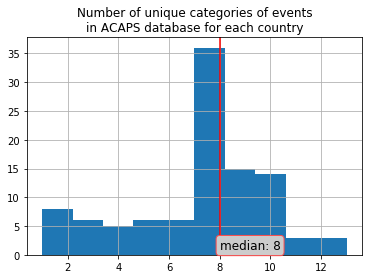

In [101]:
import matplotlib.pyplot as plt

acaps_data_summary.num_unique_keywords.hist()

median_pos = acaps_data_summary.num_unique_keywords.median()
plt.title('Number of unique categories of events\nin ACAPS database for each country')
def plot_median(med_pos):
    plt.axvline(x=med_pos,color='red')
    plt.text(median_pos, 1, 'median: ' + str(int(med_pos)), fontsize=12,
             horizontalalignment='left',
            bbox=dict(boxstyle="round",
                       ec=(1.0, 0.3, 0.3),
                       fc=(0.8, 0.8, 0.8)))
    
plot_median(median_pos)
plt.show()

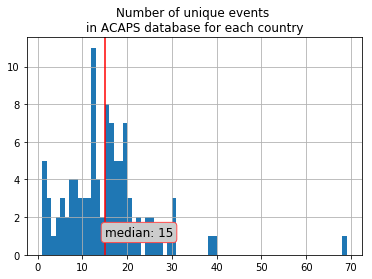

In [102]:
import matplotlib.pyplot as plt

acaps_data_summary.num_unique_events.hist(bins=range(1,70))
plt.title('Number of unique events \nin ACAPS database for each country')
median_pos = acaps_data_summary.num_unique_events.median()
plot_median(median_pos)

plt.show()

#### How does this compare?

In [184]:
ef_regions = ef_cm.Country.unique()
ef_countries = ef_regions[[s.find('US:')!=0 for s in ef_regions]] #exclude US 
len(ef_countries)

96

In [185]:
ef_countries

array(['Austria', 'Germany', 'United Kingdom', 'Vietnam', 'South Korea',
       'Singapore', 'Israel', 'Japan', 'Sweden', 'San Marino', 'Slovenia',
       'Canada', 'Hong Kong', 'Taiwan', 'Macau', 'China', 'United States',
       'European Union', 'Thailand', 'Italy', 'Czechia', 'Australia',
       'Trinidad and Tobago', 'Qatar', 'North Korea', 'New Zealand',
       'Colombia', 'Romania', 'France', 'Portugal', 'Spain', 'Belgium',
       'Luxembourg', 'Albania', 'Andorra', 'Azerbaijan', 'Belarus',
       'Bosnia and Herzegovina', 'Bulgaria', 'Denmark', 'Estonia',
       'Cyprus', 'Croatia', 'Finland', 'Georgia', 'Hungary', 'Latvia',
       'Lithuania', 'Greece', 'Moldova', 'Malta', 'Monaco', 'Netherlands',
       'Iceland', 'Guernsey', 'Macedonia', 'Ireland', 'Vatican City',
       'Jersey', 'Kosovo', 'Kazakhstan', 'Poland', 'Turkey', 'Ukraine',
       'Slovakia', 'Serbia', 'Switzerland', 'Norway', 'Montenegro',
       'Iran', 'Liechtenstein', 'Russia', 'Mexico', 'Egypt', 'Palestine',
 

In [186]:
ef_data_summary = (ef_cm
    .loc[ef_cm.Country.isin(ef_countries),:]
     .groupby('Country').apply(my_agg).reset_index()
     )

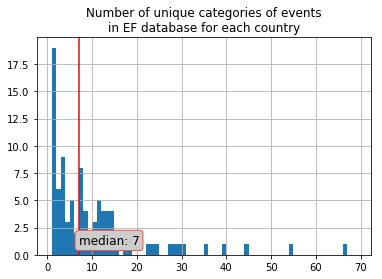

In [187]:
ef_data_summary.num_unique_keywords.hist(bins=range(1,70))
median_pos = ef_data_summary.num_unique_keywords.median()
plt.title('Number of unique categories of events\nin EF database for each country')
plot_median(median_pos)
plt.show()

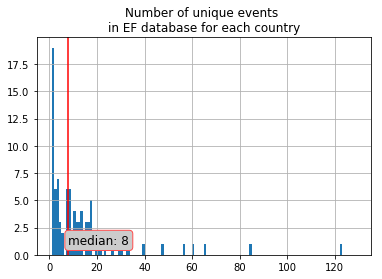

In [188]:
ef_data_summary.num_unique_events.hist(bins=range(1,130))
plt.title('Number of unique events \nin EF database for each country')
median_pos = ef_data_summary.num_unique_events.median()
plot_median(median_pos)

plt.show()

## Is the data high quality?

Let's take a look at the most common categories in the ACAPS to EF data, and based on the full-text description, manuallly judge whether the categorization makes sense. Top 3 are:

 - international travel ban - risk countries	63.0	484.0
 - hospital specialisation - partial	NaN	455.0
 - blanket curfew - no symptoms

In [189]:
from IPython.display import display, Markdown, Latex


def show_sample_of_rows_by_country(keyword,dataset):
    country_sample = np.random.choice(dataset[dataset.Keywords==keyword].Country.unique(),5)
#    print(np.random.choice(ef_from_acaps_unique.Country.unique(),5))
    sample_rows = dataset.loc[
        dataset.Country.isin(country_sample) &
        (dataset.Keywords == keyword),
        :]

    for country in country_sample:
        display(Markdown("#### " + country))
        for rind,row in sample_rows.loc[sample_rows.Country==country,:].iterrows():

            display(Markdown(" - " + row['Description of measure implemented']))
            
def show_sample_of_rows_by_country_acaps(keyword):
    show_sample_of_rows_by_country(keyword,ef_from_acaps_unique)
show_sample_of_rows_by_country_acaps('international travel ban - risk countries')

#### Lebanon

 - travelers are not permitted to enter

 - border with Syria closed indeterminatly

 - closure of Beirut international airport and seaports as well as all other entry ports between 18 and 29 March

#### Haiti

 -  Land, sea and air borders closed to travellers.

 - Ports, airports and borders are closed for passenger traffic. However, goods and medicines continue to circulate normally.

#### Oman

 - Tourists, for 30 days

 - Stopping entry of cruise ships to the Sultanate’s ports. For 30 days

 - visitors from countries with a high prevalence of COVID-19 will not be allowed to enter the Sultanate.

 - For everyone with the exception of nationals or residents.

 - Suspended issuing new visas until further notice *except for renewal of valid resident visas.

#### El Salvador

 - As of 23:59 (local time) on March 17, El Salvador International Airport (SAL) will close all operations for 15 days. Only air cargo transportation, maintenance, and humanitarian missions will be allowed to continue operations at SAL.

 - all foreign nationals banned from entering the country for the next 21 days

#### Colombia

 - Starting 16 March, non-nationals and non-residents will be banned from entering

 - all borders closed until 30 May i.e. in addition to border with Venezuela also those with Panama, Ecuador, Peru and Brazil incl. maritime entry points

 - border with Venezuela closed

In [190]:
show_sample_of_rows_by_country_acaps('hospital specialisation - partial')

#### China

 - Construction of first makeshift hospital. First patients admitted February 5. 

 - 10 new makeshift hospital opened. 5,600 patients admitted. 

 - 16 makeshift hospitals total. 13,000 beds available. 

 - Shanghai will improve its fever clinics and add 182 new ones in the city's community health service centers in order to strengthen the screening of COVID-19 disease, according to the municipal health commission on Mar 22.

 - Chinese embassies and consulates have distributed epidemic prevention materials including masks and "health kits" to overseas students in a timely manner

 - The Chinese government will ramp up efforts from various departments to accelerate the process of exporting crucial medical supplies to the world

#### Argentina

 - Construction of 8 temporary hospitals

#### Tuvalu

 - Tuvalu allocated $370,000 grant from ADB for COVID-19 response

#### Cabo Verde

 - Green Line 800 11 12, available to the public with requests for information and handling of suspicious cases, 24/7 is working well

 - Ulisses Correia e Silva said that he attested that 'there is enough disinfectant gel necessary to supply the market during this period of high demand', as well as recognizing sufficient stock of medicine and personal protective equipment to face the current situation.

 - 179 more nurses are recruited and are being placed to reinforce health services in the various municipalities in the country.

#### Mozambique

 - Govt redirecting the industrial sector towards the production of consumables necessary for the prevention of a pandemic and ensuring the adoption of preventative actions in all institutions, public or private.

 - External consultations in any health facility cancelled; priority care established

 - Donors will support fight against Covid-19 in kind, not cash

In [191]:
show_sample_of_rows_by_country_acaps('blanket curfew - no symptoms')

#### Peru

 - Forced quarantine for two weeks, travels are regulated and limited to buying basic food and pharmaceuticals.

 - National curfew between 8pm and 5am.

 - Nationwide curfew between the hours of 18:00 to 05:00. 

 - Extension of the obligatory quarantine, until 12th of April.

 - National curfew from from 6:00 p.m. – 5:00 a.m. for most of Peru (including Lima and Cusco).

 - Extension of the obligatory quarantine, until 26th of April.

 - On Mondays, Wednesday and Fridays, only men will be allowed out of their homes. On Tuesdays, Thursdays and Saturdays, only women will be allowed out of their homes. On Sundays, no one will be allowed out of their homes.

 - Gender-specific restrictions on movement will be lifted from 13 April, after which men and women will be allowed to leave home for urgent issues on any day Monday - Saturday. The Sunday curfew remains.

 - Full-day curfew for both men and women on 9th and 10th of April. People will not be allowed out of their homes or accommodation on these days.

#### Philippines

 - Full lock-down of the multiple regions with only essential services remaining and people allowed to leave their home for those; some include restrictions on leaving the municipality

 - Many local government units (including in Metro Manila) have announced overnight curfews (most commonly between 2000 and 0500)

 - Full 24h curfew for students and elderly 

 - Duterte approves Luzon-wide ECQ extension until April 30. The entire Luzon is currently under an enhanced community quarantine from which strictly requires residents to stay indoors and limits movement to accessing basic necessities and heightens the presence of uniformed personnel.

#### Guatemala

 - effective Sunday, March 22, a nationwide curfew will take effect. The curfew is from 4:00 p.m. to 4:00 a.m. and is scheduled to be in effect until March 29. Everyone in Guatemala, including foreigners, is expected to remain in their homes during curfew hours. The only exceptions are for police, private security, medical professionals and ambulances, food delivery drivers, and certain other essential personnel. While food delivery service will continue during the curfew, grocery stores are expected to close before the curfew takes effect. The Guatemalan police and security forces will enforce the curfew.

 - On March 28, Guatemala extended their curfew through to April 12.

 - Under curfew extension - The curfew lasts from 4:00 p.m. to 4:00 a.m. each day. Every individual in Guatemala — including U.S. citizens — is required to remain inside their domicile during curfew hours (with exceptions for health and security).

 - Under curfew extension - grocery and restaurant delivery services are no longer allowed to operate between 4:00 p.m. and 4:00 a.m.

#### Lesotho

 - Lesotho goes into lockdown until the 21st of April. Residents will still be permitted to buy food and seek medical care during this period. Emergency responders, health workers, and security service staff are exempt from the lockdown measures. 

#### Mali

 - National curfew between 9pm and 5am.

In [192]:
ef_cm.Keywords.value_counts()[1:50]

outdoor gatherings banned                                             72
international travel ban - risk countries                             71
school closure                                                        67
nonessential business suspension                                      45
sports cancellation                                                   38
international travel ban - all countries                              36
case reporting, first case                                            32
first case                                                            30
public announcement                                                   30
school closure, university closure                                    29
closure nonessential stores, nonessential business suspension         28
blanket isolation - no symptoms, compulsory isolation                 27
case reporting                                                        24
international traveller quarantine - risk countries

In [193]:
ef_cm.loc[ef_cm.Keywords=='hospital specialisation',: ]

,ID,Applies To,Country,Date Start,Date end intended,Description of measure implemented,Exceptions,Implementing City,Implementing State/Province,Keywords,Quantity,Source,Target city,Target country,Target region,Target state,DataSource
54,NaN,NaN,South Korea,2020-03-13,NaT,Use designated public relief hospitals- where ...,NaN,NaN,NaN,hospital specialisation,NaN,https://www.cdc.go.kr/board/board.es?mid=a2050...,NaN,NaN,NaN,NaN,EF
290,151,NaN,Romania,2020-01-22,NaT,Romanian government announced several preventi...,NaN,NaN,NaN,hospital specialisation,NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN,EF
390,255,NaN,Finland,2020-03-16,2020-04-13,Outsiders are forbidden from entering healthca...,NaN,NaN,NaN,hospital specialisation,NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN,EF
1014,NaN,NaN,South Korea,2020-03-11,NaT,Seoul City- continuously installing and expand...,NaN,NaN,NaN,hospital specialisation,NaN,https://news.naver.com/main/read.nhn?mode=LSD&...,NaN,NaN,NaN,NaN,EF
1109,NaN,NaN,Nepal,2020-01-23,NaT,"On 23 January, Dr. Bashudev Pandey, director o...",NaN,NaN,NaN,hospital specialisation,NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN,EF
1129,NaN,NaN,Slovakia,2020-03-24,NaT,3 hospitals specialized for coronavirus patien...,NaN,NaN,NaN,hospital specialisation,2000.0,https://slovensko.hnonline.sk/2118153-nove-opa...,NaN,NaN,NaN,NaN,EF
1150,NaN,NaN,Hungary,2020-03-16,NaT,The Honvéd Hospital will operate as a pre-exam...,NaN,NaN,NaN,hospital specialisation,1000.0,http://abouthungary.hu/news-in-brief/coronavir...,NaN,NaN,NaN,NaN,EF
1152,NaN,NaN,Hungary,2020-03-18,NaT,Several hospitals designated as quarantine cen...,NaN,NaN,NaN,hospital specialisation,2000.0,http://abouthungary.hu/news-in-brief/coronavir...,NaN,NaN,NaN,NaN,EF
1343,NaN,NaN,South Korea,2020-03-20,NaT,As a hospital for the general public concerned...,NaN,NaN,NaN,hospital specialisation,NaN,https://www.cdc.go.kr/board/board.es?mid=a2050...,NaN,NaN,NaN,NaN,EF


In [194]:
show_sample_of_rows_by_country('healthcare specialisation - partial', ef_cm)

ValueError: 'a' cannot be empty unless no samples are taken

## Save

In [195]:

combined_ds.to_csv("../../../data/epidemicforecasting/epimodel-covid-data/dataimport/ef_acaps_combined.csv")

In [196]:
ef_from_acaps_unique.loc[ef_from_acaps_unique.Keywords=='international travel ban - risk countries']

,Keywords,confidence,Date Start,Description of measure implemented,Implementing State/Province,Country,Source,Keyword,_merge,DataSource
3,international travel ban - risk countries,NaN,2020-02-24,Closure of borders with Iran,NaN,Afghanistan,"Guardian (Media, https://www.theguardian.com/g...",NaN,NaN,ACAPS
40,international travel ban - risk countries,NaN,2020-03-14,"Land borders: Montenegro (March 16, 2020), Kos...",NaN,Albania,"US Embassy of Albania (Government, https://al...",NaN,NaN,ACAPS
41,international travel ban - risk countries,NaN,2020-03-23,No ferries to and from Italy until april 3,NaN,Albania,"International SOS (Other organisations, https:...",NaN,NaN,ACAPS
67,international travel ban - risk countries,NaN,2020-03-17,All land borders.,NaN,Algeria,"US embassy of Algeria (Government, https://dz....",NaN,NaN,ACAPS
68,international travel ban - risk countries,NaN,2020-03-17,All neighboring land countries,NaN,Algeria,"US Embassy Algeria (Government, https://dz.use...",NaN,NaN,ACAPS
85,international travel ban - risk countries,NaN,2020-04-03,"individuals who have transited through China, ...",NaN,Angola,"GardaWorld (Other organisations, https://www.g...",NaN,NaN,ACAPS
86,international travel ban - risk countries,NaN,2020-01-03,Authorities are temporarily banning citizens o...,NaN,Angola,"GardaWorld (Other organisations, https://www.g...",NaN,NaN,ACAPS
144,international travel ban - risk countries,NaN,2020-11-03,For long term,NaN,Argentina,Ministry of Foreign Affairs - Francce (Governm...,NaN,NaN,ACAPS
146,international travel ban - risk countries,NaN,2020-03-15,For non-residents and travellers from the Sche...,NaN,Argentina,Ministry of Foreign Affairs - France (Governme...,NaN,NaN,ACAPS
159,international travel ban - risk countries,NaN,2020-03-26,Border closure is extended until 31st of March.,NaN,Argentina,"MoH (Government, https://www.boletinoficial.go...",NaN,NaN,ACAPS
